# Ohyb prostého nosníku
- prostý nosník zatížený rovnoměrným zatížením (vlastní tíha a užitné zatížení)
- ocelový nosník I S235

In [1]:
from __future__ import print_function

import openturns as ot
from openturns.viewer import View
import math as m
from collections import OrderedDict
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#%matplotlib nbagg

In [3]:
def plot_grid(marginals, inp, out, DP=None):
    n = len(marginals)
    fig, ax = plt.subplots(nrows=1, ncols=int((n-1)*n/2), figsize=(10*n, 4), tight_layout=True)
    k = 0
    for i in [0]:#range(n-1):
        for j in [1]:#range(i+1, n):
            mask = out[:,0] < 0
            ax[k].plot(inp[:, i][~mask], inp[:, j][~mask], 'g.', ms=1)
            ax[k].plot(inp[:, i][mask], inp[:, j][mask], 'r.', ms=1)
            ax[k].set_xlabel(marginals[i].getDescription()[0])
            ax[k].set_ylabel(marginals[j].getDescription()[0])
            if DP:
                ax[k].plot(DP[i], DP[j], 'co')
            k+=1

## Výpočet
- mezní stav únosnosti
$$ Z = R - E $$
$$ E = M_E = \dfrac{(q + q) l^2}{8} $$
$$ R = M_R = f_y w_\text{pl} $$

- mezní stav použitelnosti
$$ Z_w = R - E $$
$$ E = w_\text{lim} = \frac{l}{200} $$
$$ R = w = \dfrac{5}{384 E I} (q + q) l^4$$

## Náhodné veličiny
Všechny náhodné veličiny jsou uvažovány nezávislé.

<!--
|Name              | Distribution      | Mean |  Std | CoV  |  min | max |
| :--------------- |:----------------- | ---- | ---- | ---- | ---- | --- |
| $R$              | Lognormal         | 315  | 37.8 | 0.12 |      |     |
| $\gamma_{\rm m}$ | Normal            |   24 |  1.2 | 0.05 |      |     |
| $q$              | LogNormal         |    4 |  0.4 |  0.1 |      |     |
| $\varphi$        | Truncated Normal  |   33 | 4.95 | 0.15 | 31   | 36  |
| $\gamma_{\rm z}$ | Normal            |   20 |    2 |  0.1 |      |     |
-->

# Řešení pomocí openturns

In [4]:
dim = 7 # počet náhodných veličin

# parametry vstupních náhodných veličin
mu_q = 4
cov_q = 0.15
std_q = mu_q * cov_q

mu_g = 2.9
cov_g = 0.075
std_g = mu_g * cov_g

mu_l = 3.25
cov_l = 0.001
std_l = mu_l * cov_l

mu_wpl = 6.36e-5
cov_wpl = 0.04
std_wpl = mu_wpl * cov_wpl

mu_fy = 265
cov_fy = 0.07
std_fy = mu_fy * cov_fy

mu_e = 220
cov_e = 0.03
std_e = mu_e * cov_e

mu_iy = 3.27e-3
cov_iy = 0.001
std_iy = mu_iy * cov_iy

## Definice rezervy spolehlivosti
### Varianta 1 - čitelnější, ale pomalejší

In [5]:
def regularFunc(x):
    q = x[0]
    g = x[1]
    l = x[2]
    wpl = x[3]
    fy = x[4]
    
    R = fy * wpl * 1000
    E = (g + q) * l**2 / 8
    return [R - E]

limitStatePy = ot.PythonFunction(dim, 1, regularFunc)

### Varianta 2 - rychlejší

In [6]:
GM = '''(fy * wpl * 1000) - ((g + q) * l*l / 8.)'''
Gw = '''(l / 200. * 1000) - (5/384.*  (g + q) * l^4 / e / iy)'''

G = GM
var_list = ['q', 'g', 'l', 'wpl', 'fy', 'e', 'iy']

limitState = ot.SymbolicFunction(var_list, [G])
limitState = ot.MemoizeFunction(limitState) # save history

### Otestování funkcí na středních hodnotách

In [7]:
x = [mu_q, mu_g, mu_l, mu_wpl, mu_fy, mu_e, mu_iy]
print('x =', x)
%timeit limitState(x)
print('G(x) =', limitState(x))
%timeit limitStatePy(x)
print('G(x) =', limitStatePy(x))

x = [4, 2.9, 3.25, 6.36e-05, 265, 220, 0.00327]
4.79 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
G(x) = [7.74384]
7.79 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
G(x) = [7.74384]


## Definice pravděpodobnostních rozdělení náhodných veličin

In [8]:
q_dist = ot.LogNormalMuSigma(mu_q, std_q).getDistribution()
q_dist.setDescription(['q'])

g_dist = ot.Normal(mu_g, std_g)
g_dist.setDescription(['g'])

l_dist = ot.Normal(mu_l, std_l)
l_dist.setDescription(['l'])

wpl_dist = ot.Normal(mu_wpl, std_wpl)
wpl_dist.setDescription(['wpl'])

fy_dist = ot.LogNormalMuSigma(mu_fy, std_fy).getDistribution()
fy_dist.setDescription(['fy'])

e_dist = ot.LogNormalMuSigma(mu_e, std_e).getDistribution()
q_dist.setDescription(['e'])

iy_dist = ot.Normal(mu_iy, std_iy)
iy_dist.setDescription(['iy'])

marginals = [q_dist, g_dist, l_dist, wpl_dist, fy_dist, e_dist, iy_dist]

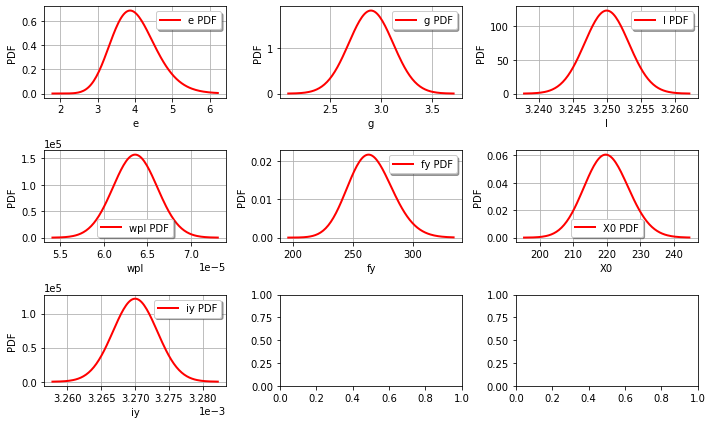

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,6), tight_layout=True)
View(q_dist.drawPDF(), axes=[ax[0, 0]], legend_kwargs=dict(loc='best'))
View(g_dist.drawPDF(), axes=[ax[0, 1]], legend_kwargs=dict(loc='best'))
View(l_dist.drawPDF(), axes=[ax[0, 2]], legend_kwargs=dict(loc='best'))
View(wpl_dist.drawPDF(), axes=[ax[1, 0]], legend_kwargs=dict(loc='best'))
View(fy_dist.drawPDF(), axes=[ax[1, 1]], legend_kwargs=dict(loc='best'));
View(e_dist.drawPDF(), axes=[ax[1, 2]], legend_kwargs=dict(loc='best'));
View(iy_dist.drawPDF(), axes=[ax[2, 0]], legend_kwargs=dict(loc='best'));

### Sdružené rozdělení pravděpodobnosti

In [10]:
# Create a copula : IndependentCopula (no correlation)
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

# Instanciate one distribution object
myDistribution = ot.ComposedDistribution(marginals, aCopula)
myDistribution.setName('myDist')

In [11]:
RS = ot.CorrelationMatrix(dim)
# RS[2, 3] = -0.2 # change correlation
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R)

### Náhodné vektory
- $G$ rezerva spolehlivosti
- `myEvent` podmínka spolehlivosti $G < 0$

In [12]:
# We create a 'usual' RandomVector from the Distribution
vect = ot.RandomVector(myDistribution)

# We create a composite random vector
G = ot.CompositeRandomVector(limitState, vect) # pro použití varianty 1 limitStatePy

# We create an Event from this RandomVector
myEvent = ot.TresholdEvent(G, ot.Less(), 0.0)

## Metoda Monte Carlo

In [13]:
limitState.clearHistory()

In [14]:
cv = 0.05
NbSim = 1000000

experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(NbSim)
#algoMC.setBlockSize(4)
algoMC.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
%time algoMC.run()

CPU times: user 13.2 s, sys: 116 ms, total: 13.3 s
Wall time: 13.3 s


MonteCarlo result= probabilityEstimate=3.000000e-06 varianceEstimate=2.999991e-12 standard deviation=1.73e-06 coefficient of variation=5.77e-01 confidenceLength(0.95)=6.79e-06 outerSampling=1000000 blockSize=1
Number of executed iterations = 1000000
Number of calls to the limit state = 1000000
Pf =  2.9999999999999255e-06
CV = 0.5773494031635718


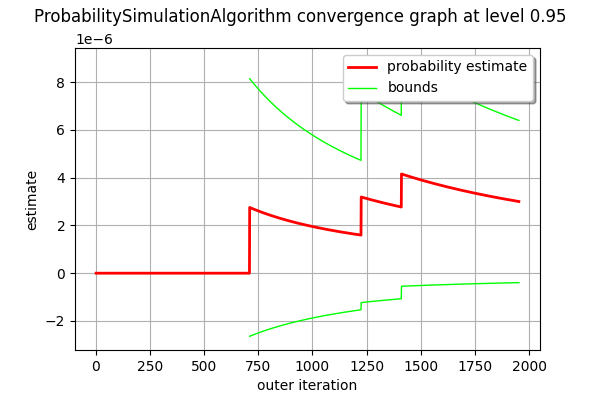

In [15]:
# Results:
resultMC = algoMC.getResult()
pf_MC = resultMC.getProbabilityEstimate()
cov_MC = resultMC.getCoefficientOfVariation()
print('MonteCarlo result=', resultMC)
print('Number of executed iterations =', resultMC.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', pf_MC)
print('CV =', cov_MC)
algoMC.drawProbabilityConvergence()

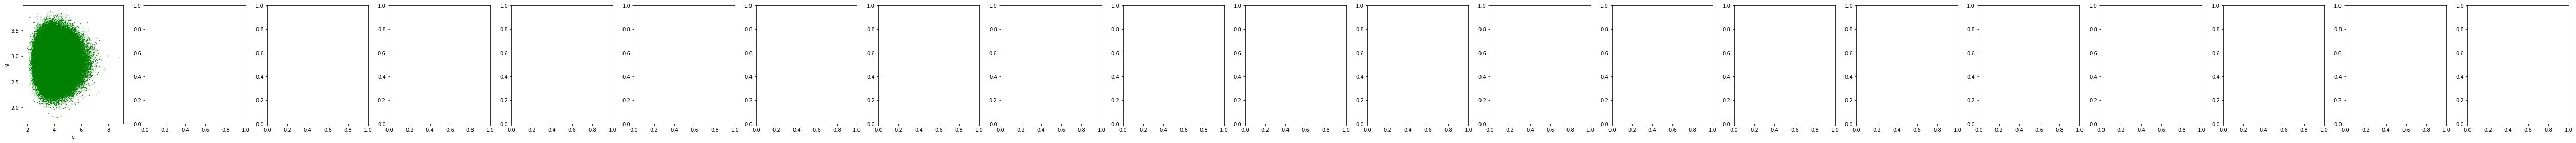

In [16]:
inpMC = np.asarray(limitState.getInputHistory())
outMC = np.asarray(limitState.getOutputHistory())
#display(inp)
#display(out)
plot_grid(marginals, inpMC, outMC)

## Metoda FORM - First Order Reliability Method

In [17]:
limitState.clearHistory()

In [18]:
# Using FORM analysis

# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
neval = 1000

myCobyla.setMaximumEvaluationNumber(neval)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# We create a FORM algorithm
# The first parameter is a NearestPointAlgorithm
# The second parameter is an event
# The third parameter is a starting point for the design point research

algoFORM = ot.FORM(myCobyla, myEvent, myDistribution.getMean())

# Perform the analysis:
algoFORM.run()

Number of calls to the limit state = 348
beta = 4.856991557307549
Pf = 5.959133689601852e-07


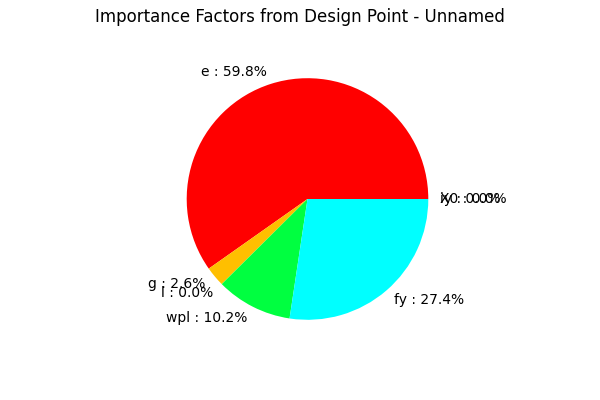

In [19]:
# Results:
resultFORM = algoFORM.getResult()
pf_FORM = resultFORM.getEventProbability()
beta_FORM = resultFORM.getHasoferReliabilityIndex()
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('beta =', beta_FORM)
print('Pf =', pf_FORM)

standardSpaceDesignPoint = resultFORM.getStandardSpaceDesignPoint()

# Graphical result output
resultFORM.drawImportanceFactors()

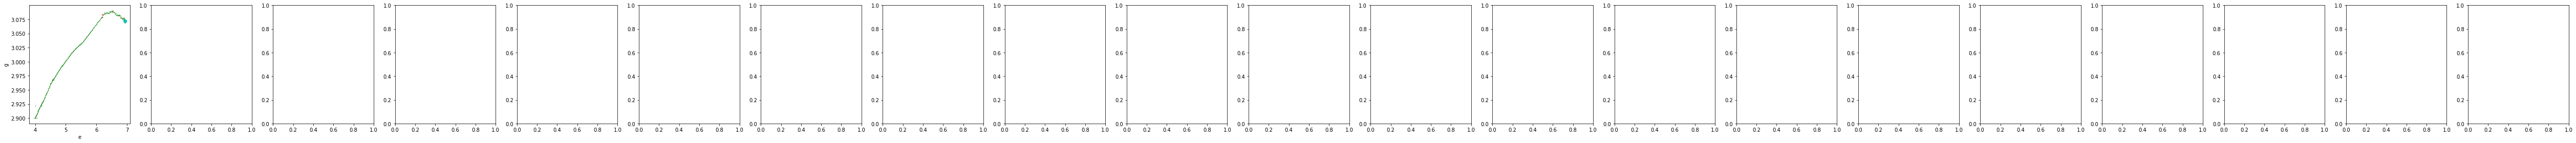

In [20]:
inpFORM = np.asarray(limitState.getInputHistory())
outFORM = np.asarray(limitState.getOutputHistory())
#display(inp)
#display(out)

DP = resultFORM.getPhysicalSpaceDesignPoint()
plot_grid(marginals, inpFORM, outFORM, DP=DP)

## Metoda LHS - Latin Hypercube Sampling

In [21]:
limitState.clearHistory()
#hist = ot.HistoryStrategy(ot.Full())

In [22]:
cv = 0.05
nsim = 1000000

algoLHS = ot.LHS(myEvent)
#algoLHS.setConvergenceStrategy(hist)
algoLHS.setBlockSize(4)
algoLHS.setMaximumCoefficientOfVariation(cv)
algoLHS.setMaximumOuterSampling(nsim)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

%time algoLHS.run()

CPU times: user 27.1 s, sys: 408 ms, total: 27.5 s
Wall time: 27.5 s


Number of calls to the limit state = 4000000
Number of calls = 1000000
CoV= 0.5590167707681827
Pf= 9.999999999998737e-07


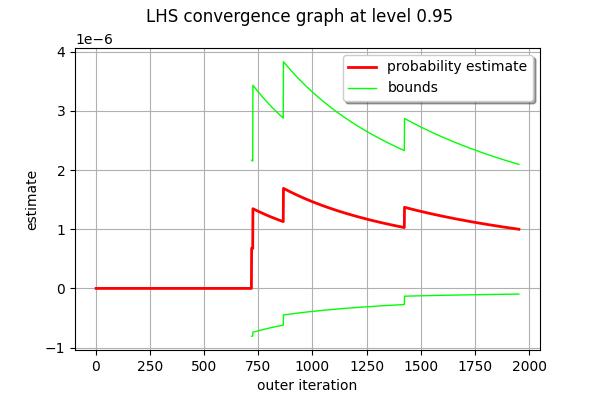

In [23]:
# retrieve results
resultLHS = algoLHS.getResult()
pf_LHS = resultLHS.getProbabilityEstimate()
cov_LHS = resultLHS.getCoefficientOfVariation()

print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Number of calls =', resultLHS.getOuterSampling())
print('CoV=', cov_LHS)
print('Pf=', pf_LHS)
#algoLHS.getConvergenceStrategy().getSamples()
algoLHS.drawProbabilityConvergence()

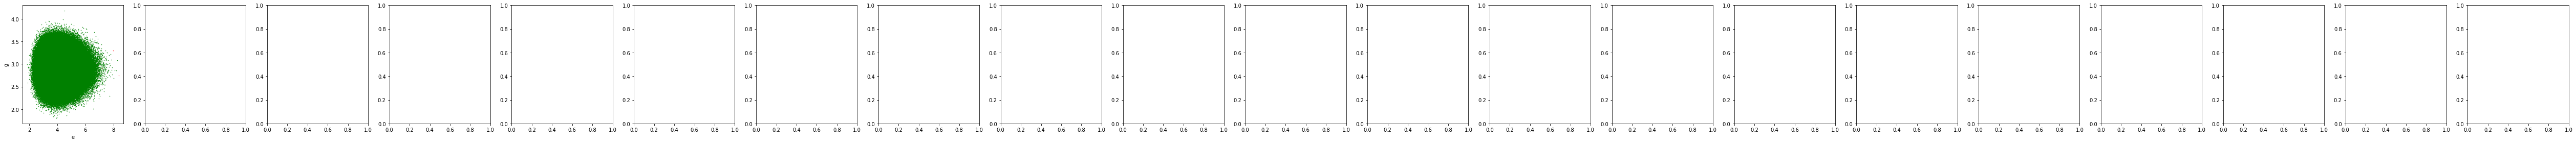

In [24]:
inpLHS = np.asarray(limitState.getInputHistory())
outLHS = np.asarray(limitState.getOutputHistory())
#display(inp)
#display(out)
plot_grid(marginals, inpLHS, outLHS)

## Metoda Importance Sampling
- pro nalezení oblasti poruchy je využit návrhový bod z metody FORM
- váhová funkce `myImportance` je mnohorozměrné normální rozdělení se směrodatnou odchylkou `impstd` pro všechny dimenze

In [25]:
limitState.clearHistory()

In [26]:
impstd = 1.0
myImportance = ot.Normal(standardSpaceDesignPoint, [impstd] * dim, ot.CorrelationMatrix(dim))

# Create a simulation algorithm
cv = 0.05
nsim = 10000

experiment = ot.ImportanceSamplingExperiment(myImportance)
algoIS = ot.ProbabilitySimulationAlgorithm(ot.StandardEvent(myEvent), experiment)
algoIS.setMaximumCoefficientOfVariation(cv)
algoIS.setMaximumOuterSampling(nsim)
algoIS.setConvergenceStrategy(ot.Full())

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

algoIS.run()

In [27]:
# retrieve results
resultIS = algoIS.getResult()
pf_IS = resultIS.getProbabilityEstimate()
cov_IS = resultIS.getCoefficientOfVariation()
print('Number of calls =', resultIS.getOuterSampling())
print('CoV=', cov_IS)
print('Pf=', pf_IS)

Number of calls = 2198
CoV= 0.0499585461129967
Pf= 6.748349770989953e-07


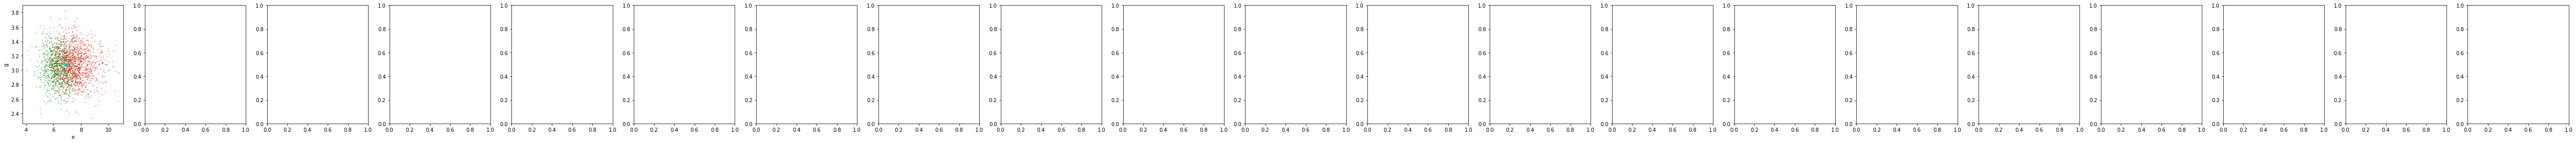

In [28]:
inpIS = np.asarray(limitState.getInputHistory())
outIS = np.asarray(limitState.getOutputHistory())
#display(inp)
#display(out)
DP = resultFORM.getPhysicalSpaceDesignPoint()
plot_grid(marginals, inpIS, outIS, DP=DP)

## METODA SORM - Second Order Reliability Method

In [29]:
limitState.clearHistory()

In [30]:
# Using SORM analysis

# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
niter = 1000

myCobyla.setMaximumEvaluationNumber(niter)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# We create a FORM algorithm
# The first parameter is a NearestPointAlgorithm
# The second parameter is an event
# The third parameter is a starting point for the design point research

algoSORM = ot.SORM(myCobyla, myEvent, myDistribution.getMean())

# Perform the analysis:
algoSORM.run()

Number of calls to the limit state = 348
beta = 4.842950133893698
Pf = 6.396270102985151e-07
Pf = 6.415435993010808e-07
Pf = 6.413295407395318e-07


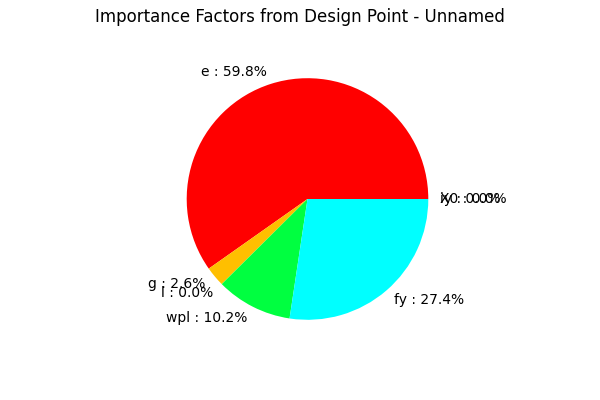

In [31]:
# Results:
resultSORM = algoSORM.getResult()
beta_SORM = resultSORM.getGeneralisedReliabilityIndexBreitung()
pf_SORM = resultSORM.getEventProbabilityBreitung()
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('beta =', beta_SORM)
print('Pf =', pf_SORM)
print('Pf =', resultSORM.getEventProbabilityHohenBichler())
print('Pf =', resultSORM.getEventProbabilityTvedt())

# Graphical result output
resultSORM.drawImportanceFactors()

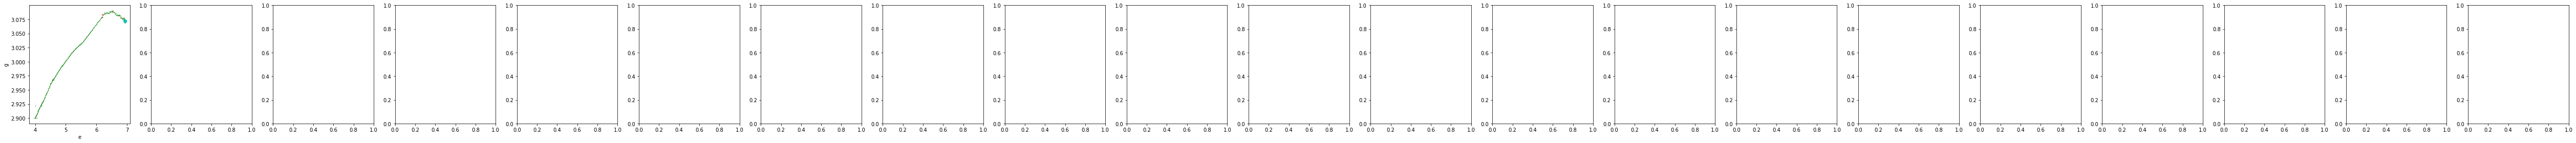

In [32]:
inpSORM = np.asarray(limitState.getInputHistory())
outSORM = np.asarray(limitState.getOutputHistory())
#display(inp)
#display(out)
DP = resultSORM.getPhysicalSpaceDesignPoint()
plot_grid(marginals, inpSORM, outSORM, DP=DP)

## Directional sampling

In [33]:
limitState.clearHistory()

In [34]:
# Using Directional sampling

# Resolution options:
cv = 0.05
NbSim = 100000

algoDS = ot.DirectionalSampling(myEvent)
algoDS.setMaximumOuterSampling(NbSim)
algoDS.setBlockSize(1)
algoDS.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoDS.run()

Number of executed iterations = 75471
Number of calls to the limit state = 1234460
Pf =  6.400259116817096e-07
CV = 0.04999793642808224


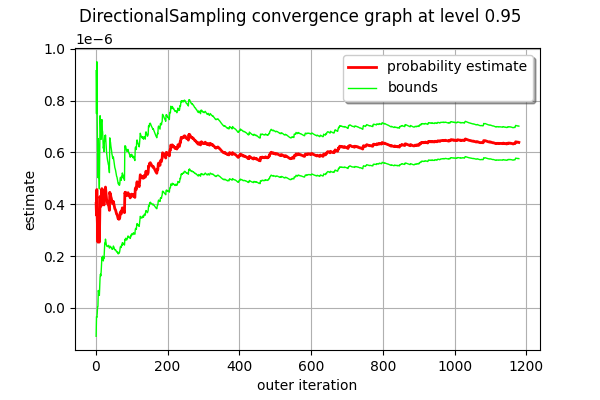

In [35]:
# Results:
resultDS = algoDS.getResult()
pf_DS = resultDS.getProbabilityEstimate()
cov_DS = resultDS.getCoefficientOfVariation()
print('Number of executed iterations =', resultDS.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', pf_DS)
print('CV =', cov_DS)
algoDS.drawProbabilityConvergence()

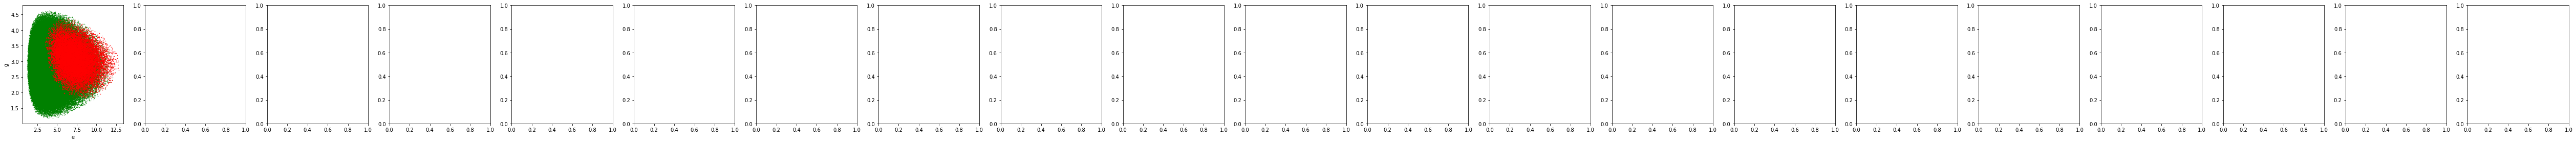

In [36]:
inpDS = np.asarray(limitState.getInputHistory())
outDS = np.asarray(limitState.getOutputHistory())
#display(inp)
#display(out)
plot_grid(marginals, inpDS, outDS)

## Fitting MC

In [37]:
factories = [ot.LogNormalFactory(), ot.NormalFactory(), ot.WeibullMinFactory()]

In [38]:
estimated_distribution, test_result = ot.FittingTest.BestModelKolmogorov(outMC, factories)
test_result

class=TestResult name=Unnamed type=Kolmogorov LogNormal binaryQualityMeasure=false p-value threshold=0.5 p-value=0 statistic=0.00159962 description=[LogNormal(muLog = 4.01907, sigmaLog = 0.0287277, gamma = -47.9265) vs sample Unnamed]

In [39]:
print('mu =', estimated_distribution.getMean())
print('sigma =', estimated_distribution.getStandardDeviation())
print('gamma_1 =', estimated_distribution.getSkewness())
print('gamma_2 =', estimated_distribution.getKurtosis())

pf_fit_MC = estimated_distribution.computeCDF(0)
print('pf =', pf_fit_MC)

mu = [7.74593]
sigma = [1.59967]
gamma_1 = [0.0862245]
gamma_2 = [3.01322]
pf = 9.927058949018644e-08


(1e-06, 1)

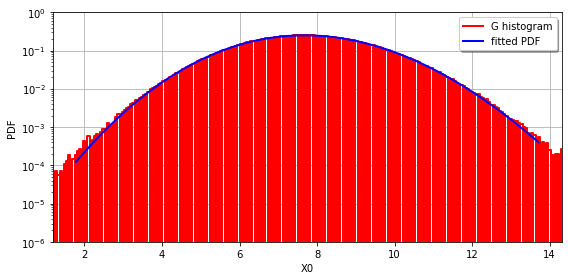

In [40]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4), tight_layout=True)
View(ot.HistogramFactory().build(outMC).drawPDF(), axes=[ax], legend_kwargs=dict(loc='best'), plot_kwargs=dict(label='G histogram'))
View(estimated_distribution.drawPDF(), axes=[ax], legend_kwargs=dict(loc='best'), plot_kwargs={'color':'b', 'label': 'fitted PDF'})
ax.set_yscale('log')
ax.set_ylim(1e-6, 1)

## Fitting LHS

In [41]:
factories = [ot.LogNormalFactory(), ot.NormalFactory(), ot.WeibullMinFactory()]

In [42]:
estimated_distribution, test_result = ot.FittingTest.BestModelKolmogorov(outLHS, factories)
test_result

class=TestResult name=Unnamed type=Kolmogorov LogNormal binaryQualityMeasure=false p-value threshold=0.5 p-value=0 statistic=0.00128502 description=[LogNormal(muLog = 4.08627, sigmaLog = 0.0268646, gamma = -51.7952) vs sample Unnamed]

In [43]:
print('mu =', estimated_distribution.getMean())
print('sigma =', estimated_distribution.getStandardDeviation())
print('gamma_1 =', estimated_distribution.getSkewness())
print('gamma_2 =', estimated_distribution.getKurtosis())

pf_fit_LHS = estimated_distribution.computeCDF(0)
print('pf =', pf_fit_LHS)

mu = [7.74385]
sigma = [1.59978]
gamma_1 = [0.0806279]
gamma_2 = [3.01156]
pf = 1.1511153209634023e-07


(1e-06, 1)

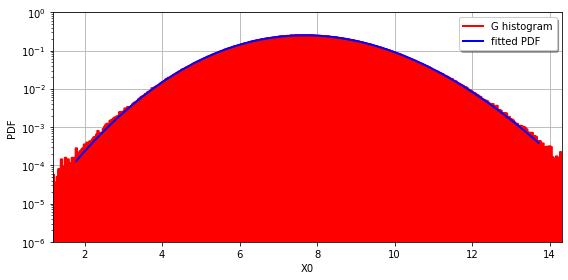

In [44]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4), tight_layout=True)
View(ot.HistogramFactory().build(outLHS).drawPDF(), axes=[ax], legend_kwargs=dict(loc='best'), plot_kwargs=dict(label='G histogram'))
View(estimated_distribution.drawPDF(), axes=[ax], legend_kwargs=dict(loc='best'), plot_kwargs={'color':'b', 'label': 'fitted PDF'})
ax.set_yscale('log')
ax.set_ylim(1e-6, 1)

## Subset Sampling

In [45]:
limitState.clearHistory()

In [46]:
cv = 0.05
NbSim = 1000

algoSS = ot.SubsetSampling(myEvent)

algoSS.setBlockSize(1)
#algoSS.setMaximumOuterSampling(NbSim)
#algoSS.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

algoSS.run()

Subset Sampling result= probabilityEstimate=7.558434e-07 varianceEstimate=8.083603e-15 standard deviation=8.99e-08 coefficient of variation=1.19e-01 confidenceLength(0.95)=3.52e-07 outerSampling=70000 blockSize=1
Number of executed iterations = 70000
Number of calls to the limit state = 70000
Pf =  7.558434000000029e-07
CV = 0.1189517041534912


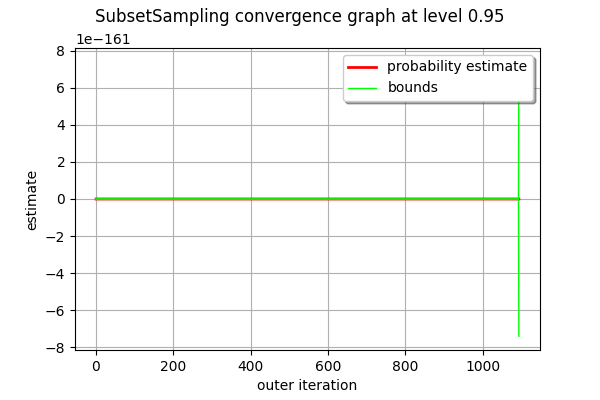

In [47]:
resultSS = algoSS.getResult()
pf_SS = resultSS.getProbabilityEstimate()
cov_SS = resultSS.getCoefficientOfVariation()
print('Subset Sampling result=', resultSS)
print('Number of executed iterations =', resultSS.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', pf_SS)
print('CV =', cov_SS)
s = algoSS.getConvergenceStrategy()
algoSS.drawProbabilityConvergence()

(70000, 1)
7 70000


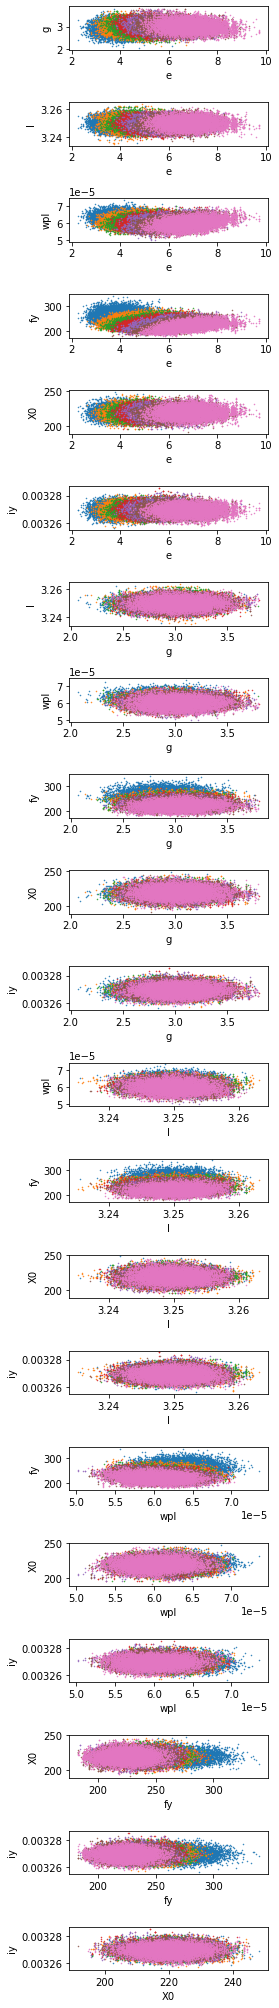

In [48]:
inpSS = np.asarray(limitState.getInputHistory())
outSS = np.asarray(limitState.getOutputHistory())
#display(inp)
#display(outSS)
print(outSS.shape)
n = len(marginals)
nit = resultSS.getOuterSampling()
ns = algoSS.getNumberOfSteps()
print(ns, nit)
fig, ax = plt.subplots(nrows=int((n-1)*n/2), ncols=1, figsize=(4, n*4), tight_layout=True)
k = 0
for i in range(n-1):
    for j in range(i+1, n):
        mask = outSS[:,0] < 0
        for l in range(ns):
            r = np.s_[int(l*nit/ns):int(nit/ns*(l+1))]
            ax[k].plot(inpSS[:, i][r], inpSS[:, j][r], ms=1, marker='.', ls='None')
        #ax[k].plot(inpSS[:, i][mask], inpSS[:, j][mask], ms=1, marker='.', ls='None')
        ax[k].set_xlabel(marginals[i].getDescription()[0])
        ax[k].set_ylabel(marginals[j].getDescription()[0])
        k+=1

## Adaptive Directional Sampling

In [49]:
limitState.clearHistory()

In [50]:
cv = 0.05
NbSim = 1000

algoADS = ot.AdaptiveDirectionalSampling(myEvent)
#algoADS.setMaximumOuterSampling(NbSim)
#algoADS.setBlockSize(1)
#algoADS.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
%time algoADS.run()

CPU times: user 458 ms, sys: 0 ns, total: 458 ms
Wall time: 463 ms


In [51]:
# Results:
resultADS = algoADS.getResult()
pf_ADS = resultADS.getProbabilityEstimate()
cov_ADS = resultADS.getCoefficientOfVariation()
print('Number of executed iterations =', resultADS.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', pf_ADS)
print('CV =', cov_ADS)
#algoADS.drawProbabilityConvergence()

Number of executed iterations = 880
Number of calls to the limit state = 7482
Pf =  3.129332207855553e-07
CV = 0.0398771450309289


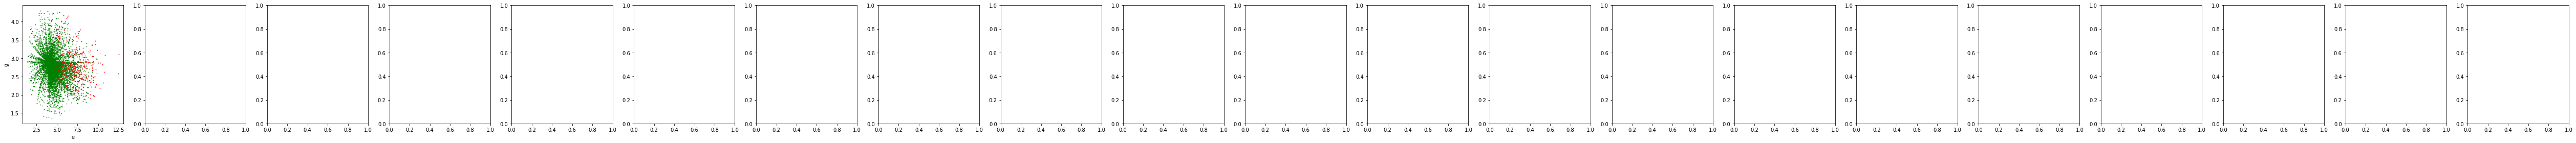

In [52]:
inpADS = np.asarray(limitState.getInputHistory())
outADS = np.asarray(limitState.getOutputHistory())
#display(inp)
#display(out)
plot_grid(marginals, inpADS, outADS)

In [54]:
print('MC =', pf_MC)
print('LHS =', pf_LHS)
print('FORM =', pf_FORM)
print('SORM =', pf_SORM)
print('SS =', pf_SS)
print('DS =', pf_DS)
print('ADS =', pf_ADS)
print('fit MC =', pf_fit_MC)
print('fit LHS =', pf_fit_LHS)

MC = 2.9999999999999255e-06
LHS = 9.999999999998737e-07
FORM = 5.959133689601852e-07
SORM = 6.396270102985151e-07
SS = 7.558434000000029e-07
DS = 6.400259116817096e-07
ADS = 3.129332207855553e-07
fit MC = 9.927058949018644e-08
fit LHS = 1.1511153209634023e-07
